# CSC412/2506 (Winter 2022) Probabilistic ML: Homework 3

- **Deadline**: 03/22 23:59
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

## Your Info

- **Name: Lisa Yu**
- **Student Number: 1005786366**
- **Collaborators: N/A**

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [543]:
!pip install wget
import os
import os.path
import matplotlib.pyplot as plt
import wget
import jax
import jax.numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt

from jax import jit, grad
from jax.ops import index_update
from jax.random import PRNGKey, normal, split, uniform
from jax.scipy.stats import norm
from jax import random, vmap
from jax.example_libraries import optimizers
from tqdm import trange, tqdm_notebook
from functools import partial

# 1.1 [0pts] Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [544]:
def log_joint_prior(zs_array):
    return np.sum(norm.logpdf(zs_array, 0.0, 1.0), axis=-1)

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [545]:
def logp_a_beats_b(z_a, z_b):
    return -np.logaddexp(0.0, z_b - z_a)

def log_prior_over_2_players(z1, z2):
    return norm.logpdf(z1, 0.0, 1.0) + norm.logpdf(z2, 0.0, 1.0)

def prior_over_2_players(z1, z2):
    return np.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return np.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return np.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return np.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [546]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101, cmap="summer"):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()    

## **1.2 [25pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [15pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: Instead of including batch dimensions, you can simply use the `vmap` higher-order function, which takes in a function and returns another one that broadcasts the first function along a new axis.

Hint 3: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [547]:
def diag_gaussian_sample(rng, mean, log_std):
  # Take a single sample from a diagonal multivariate Gaussian.
  return mean + random.normal(rng, mean.shape) * np.exp(log_std) # TODO.  You might want to use random.normal(), but remember
  # you must use the reparameterization trick.  Also remember that
  # we are parameterizing the _log_ of the standard deviation.

def diag_gaussian_logpdf(x, mean, log_std):
  # Evaluate the density of single point on a diagonal multivariate Gaussian.
  return np.sum(vmap(norm.logpdf)(x, mean, np.exp(log_std)))# TODO

def elbo(logprob, rng, mean, log_std):
  # Single-sample Monte Carlo estimate of the variational lower bound.
  sampled_zs = diag_gaussian_sample(rng, mean, log_std) # TODO
  return logprob(sampled_zs) - diag_gaussian_logpdf(sampled_zs, mean, log_std) # TODO 

def batch_elbo(logprob, rng, params, num_samples):
  # Average over a batch of random samples. 
  rngs = random.split(rng, num_samples)
  vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
  elbo_estimates = vectorized_elbo(rngs, *params)
  return np.mean(elbo_estimates) # TODO: Use simple Monte Carlo to combine your estimates
  


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [548]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[0], z1z2[1])

def objective(params, t):  # The loss function to be minimized.
  rng = random.PRNGKey(t)
  return - batch_elbo(log_posterior_A_beat_B_10_times_1_arg, rng, params, num_samples_per_iter) # TODO.  Hint:  This can be done in one line.

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


 19%|█▉        | 151/800 [00:01<00:06, 107.41it/s]

Iteration 0 lower bound 4.891197204589844
Iteration 25 lower bound 3.1868278980255127
Iteration 50 lower bound 3.023127317428589
Iteration 75 lower bound 3.071540355682373
Iteration 100 lower bound 2.922780990600586
Iteration 125 lower bound 3.0607519149780273
Iteration 150 lower bound 2.961629629135132
Iteration 175 lower bound 2.933382272720337
Iteration 200 lower bound 2.9295947551727295
Iteration 225 lower bound 3.0403811931610107
Iteration 250 lower bound 2.9081027507781982
Iteration 275 lower bound 3.0254149436950684


 53%|█████▎    | 427/800 [00:02<00:01, 353.50it/s]

Iteration 300 lower bound 2.9337174892425537
Iteration 325 lower bound 2.915977716445923
Iteration 350 lower bound 3.0472400188446045
Iteration 375 lower bound 3.0245959758758545
Iteration 400 lower bound 2.900169849395752
Iteration 425 lower bound 3.005176067352295
Iteration 450 lower bound 2.902907133102417
Iteration 475 lower bound 3.0870468616485596
Iteration 500 lower bound 2.9341256618499756
Iteration 525 lower bound 2.8127903938293457
Iteration 550 lower bound 3.1425201892852783


100%|██████████| 800/800 [00:02<00:00, 328.27it/s]

Iteration 575 lower bound 3.099687099456787
Iteration 600 lower bound 2.7920756340026855
Iteration 625 lower bound 2.961297035217285
Iteration 650 lower bound 3.0898985862731934
Iteration 675 lower bound 2.948496103286743
Iteration 700 lower bound 2.8852970600128174
Iteration 725 lower bound 2.9486148357391357
Iteration 750 lower bound 2.8670501708984375
Iteration 775 lower bound 2.976224660873413


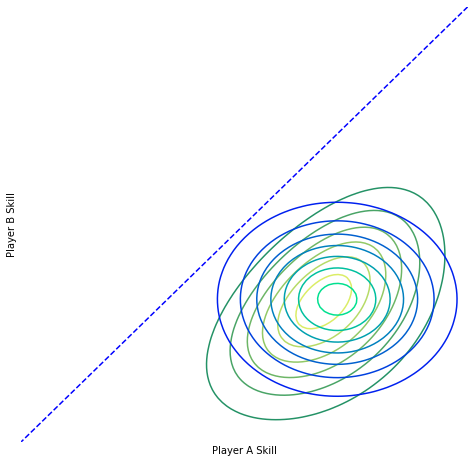

<Figure size 432x288 with 0 Axes>

In [549]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params, t)))

# Set up optimizer.
D = 2
init_mean     = np.zeros(D)
init_log_std  = np.zeros(D) # TODO.
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)

In [550]:
print(objective(params, n_iters))

2.9978595


ANSWER to 1.2c:

The final loss is negative batch lower bound = 2.9978595

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [551]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
  return log_posterior_beat_each_other_10_times(z1z2[0], z1z2[1]) # TODO

def objective(params, t):
  rng = random.PRNGKey(t)
  return - batch_elbo(log_posterior_beat_each_other_10_times_1_arg, rng, params, num_samples_per_iter) # TODO

**e) [2pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


100%|██████████| 100/100 [00:01<00:00, 52.94it/s]

Iteration 0 lower bound 17.62453269958496
Iteration 25 lower bound 15.784343719482422
Iteration 50 lower bound 15.823676109313965
Iteration 75 lower bound 15.860443115234375


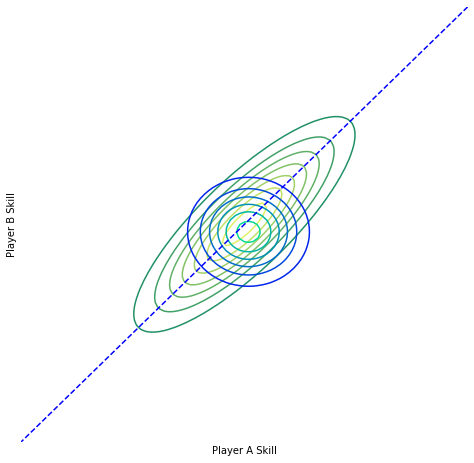

<Figure size 432x288 with 0 Axes>

In [552]:
@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

def approx_posterior_2d(z1, z2):
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)


In [553]:
print(objective(params, n_iters))

15.671027


ANSWER to 1.2e:

The final loss is negative batch lower bound = 15.671027

Under the true posterior, it is plausible for both player A's skill and player B's skill to be around the same but both high (above mid point) or both low (below mid point). However, this is not plausible under the approximate posterior.

changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian would probably make a better approximation in this instance since the additional covariance information adds model complexity. (The z_i's given the games data should not be independent in real life)

## 1.3 [25pts] Approximate inference conditioned on real data

The dataset from $\texttt{tennis_data.mat}$ contains data on 1801 tennis games amongst 107 players:
 - W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.





In [554]:
wget.download("https://probmlcourse.github.io/csc412/assignments/assignment_2/tennis_data.mat")
data = scipy.io.loadmat('tennis_data.mat')

games = data['G'] - 1 # A list of pairs of player numbers, representing game outcomes. (shape (1081, 2))
names = data['W']     # A list of names of players, corresponding to the player numbers. (shape (107, 1))

print(games[0,:])
print(names[0])

[0 1]
[array(['Rafael-Nadal'], dtype='<U12')]




**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [555]:
def log_games_likelihood(zs, games):
  # matches is an array of size (num_games x 2)
  # zs is an array of size (num_players, num_samples)

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_skills = zs[winning_player_ixs] 
  losing_player_skills = zs[losing_player_ixs] 
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills) 
  return np.sum(log_likelihoods)

In [556]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset. Report the final negative ELBO estimate after optimization.

In [557]:
# Hyperparameters
num_players = 107
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150
key = PRNGKey(0)

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_joint_probability, rng, params, num_samples_per_iter) # TODO

**c) [1pts]** Optimize, and report the final loss. 

In [558]:
# Set up optimizer.
init_mean = np.zeros(num_players)
init_std  = np.zeros(num_players)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


Optimizing variational parameters...


  3%|▎         | 15/500 [00:02<00:50,  9.61it/s]

Iteration 0 lower bound 1186.4822998046875


  8%|▊         | 38/500 [00:02<00:16, 28.77it/s]

Iteration 25 lower bound 1172.82373046875


 15%|█▍        | 74/500 [00:02<00:06, 65.39it/s]

Iteration 50 lower bound 1146.538330078125


 17%|█▋        | 86/500 [00:02<00:06, 63.18it/s]

Iteration 75 lower bound 1144.3675537109375


 23%|██▎       | 113/500 [00:03<00:06, 62.52it/s]

Iteration 100 lower bound 1144.5655517578125


 27%|██▋       | 137/500 [00:03<00:05, 63.99it/s]

Iteration 125 lower bound 1144.3048095703125


 32%|███▏      | 162/500 [00:04<00:05, 67.59it/s]

Iteration 150 lower bound 1144.0535888671875


 37%|███▋      | 184/500 [00:04<00:05, 57.40it/s]

Iteration 175 lower bound 1144.306884765625


 42%|████▏     | 212/500 [00:05<00:05, 50.83it/s]

Iteration 200 lower bound 1144.236328125


 48%|████▊     | 238/500 [00:05<00:04, 57.36it/s]

Iteration 225 lower bound 1144.291748046875


 52%|█████▏    | 262/500 [00:05<00:03, 65.14it/s]

Iteration 250 lower bound 1143.934814453125


 57%|█████▋    | 285/500 [00:06<00:03, 64.15it/s]

Iteration 275 lower bound 1144.21728515625


 62%|██████▏   | 308/500 [00:06<00:03, 63.75it/s]

Iteration 300 lower bound 1144.195068359375


 67%|██████▋   | 336/500 [00:07<00:02, 61.69it/s]

Iteration 325 lower bound 1144.046875


 71%|███████▏  | 357/500 [00:07<00:02, 54.63it/s]

Iteration 350 lower bound 1144.3035888671875


 77%|███████▋  | 386/500 [00:08<00:02, 47.49it/s]

Iteration 375 lower bound 1144.3499755859375


 82%|████████▏ | 408/500 [00:08<00:02, 40.33it/s]

Iteration 400 lower bound 1144.807861328125


 87%|████████▋ | 434/500 [00:09<00:01, 50.37it/s]

Iteration 425 lower bound 1144.3662109375


 92%|█████████▏| 461/500 [00:09<00:00, 49.78it/s]

Iteration 450 lower bound 1143.938232421875


 96%|█████████▋| 482/500 [00:10<00:00, 53.37it/s]

Iteration 475 lower bound 1144.51611328125


100%|██████████| 500/500 [00:10<00:00, 48.38it/s]


In [559]:
print(objective(params, n_iters))

1144.9132


The final negative batch ELBO estimate after optimization is 1144.9132.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

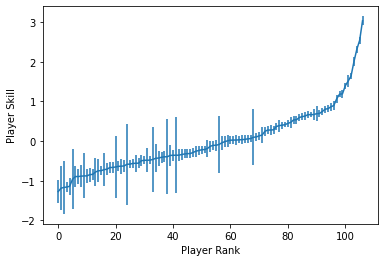

In [560]:
mean_skills, logstd_skills = params # TODO.  Hint: You don't need to do simple Monte Carlo here.
std_skills = np.exp(logstd_skills)
var_skills = np.square(std_skills)
order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(107), mean_skills[order], var_skills[order])

**e) [2pts]** List the names of the 10 players with the highest mean skill under the variational model.


In [561]:
for i in range(1,11):
    print(names[order[-i]])# TODO

[array(['Novak-Djokovic'], dtype='<U14')]
[array(['Roger-Federer'], dtype='<U13')]
[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Andy-Murray'], dtype='<U11')]
[array(['David-Ferrer'], dtype='<U12')]
[array(['Robin-Soderling'], dtype='<U15')]
[array(['Jo-Wilfried-Tsonga'], dtype='<U18')]
[array(['Juan-Martin-Del-Potro'], dtype='<U21')]
[array(['Tomas-Berdych'], dtype='<U13')]
[array(['Richard-Gasquet'], dtype='<U15')]


**f) [1pt]** Plot the joint posterior over the skills of Roger Federer and Rafael Nadal.

[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Roger-Federer'], dtype='<U13')]


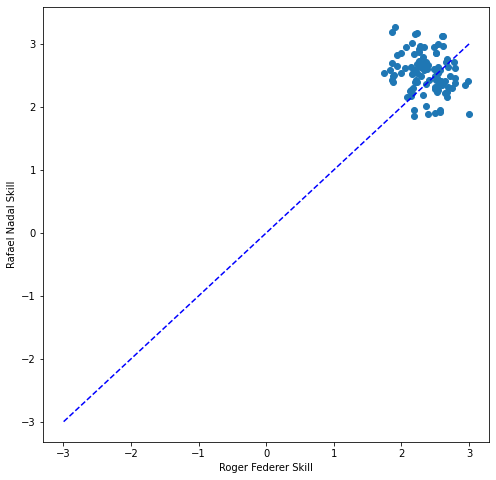

In [562]:
nadal_ix = 0
federer_ix = 4
print(names[nadal_ix])
print(names[federer_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Roger Federer Skill") 
plt.ylabel("Rafael Nadal Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

rngs = random.split(random.PRNGKey(t), 100)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, nadal_ix], samples[:, federer_ix])

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

ANSWER:

$y_A=z_A-z_B$ , $z_A \sim \mathcal N (\mu_A, \sigma^2_A)$ , $z_B \sim \mathcal N (\mu_B, \sigma^2_B)$t

Then $y_A \sim \mathcal N (\mu_A-\mu_B, \sigma^2_A + \sigma^2_B)$ Since we have a factorized Gaussian over two players’ skills ($z_A$ is independent of $z_B$)

So $\mathcal P(z_A>z_B) = \mathcal P(z_A-z_B>0) = \mathcal P(y_A>0) = 1-\mathcal P(y_A\leq0)$

$=1-\int_{-∞}^{0} \frac{1}{\sqrt{(\sigma^2_A + \sigma^2_B)2π}}exp(-\frac{(x-\mu_A+\mu_B)^2}{2(\sigma^2_A + \sigma^2_B)}) \,dx$

**h) [2pts]** Compute the probability under your approximate posterior that Roger Federer has higher skill than Rafael Nadal. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `jax.scipy.stats.norm.cdf` for the exact formula.

In [563]:
probability_z_f_greater_than_z_n = 1 - jax.scipy.stats.norm.cdf(0, mean_skills[federer_ix] - mean_skills[nadal_ix], var_skills[federer_ix] + var_skills[nadal_ix]) # TODO

rngs = random.split(random.PRNGKey(t), 10000)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

zs_f = samples[:, federer_ix]
zs_n = samples[:, nadal_ix]
probability_z_f_greater_than_z_n_Monte_Carlo = (zs_f > zs_n).sum()/10000


print("Probability that Roger Federer has higher skill than Rafael Nadal under your approximate posterior: ")
print(probability_z_f_greater_than_z_n)

print("Probability that Roger Federer has higher skill than Rafael Nadal using Monte Carlos: ")
print(probability_z_f_greater_than_z_n_Monte_Carlo)

Probability that Roger Federer has higher skill than Rafael Nadal under your approximate posterior: 
0.912033
Probability that Roger Federer has higher skill than Rafael Nadal using Monte Carlos: 
0.7112


**i) [2pts]** Compute the probability that Roger Federer is better than the player with the lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [564]:
# TODO
probability_z_f_greater_than_z_lowest = 1 - jax.scipy.stats.norm.cdf(0, mean_skills[federer_ix] - mean_skills[mean_skills.argmin()], var_skills[federer_ix] + var_skills[mean_skills.argmin()]) # TODO

rngs = random.split(random.PRNGKey(t), 10000)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

zs_f = samples[:, federer_ix]
zs_lowest = samples[:, mean_skills.argmin()]
probability_z_f_greater_than_z_lowest_Monte_Carlo = (zs_f > zs_lowest).sum()/10000


print("Probability that Roger Federer has higher skill than lowest mean skill player under your approximate posterior: ")
print(probability_z_f_greater_than_z_lowest)

print("Probability that Roger Federer has higher skill than lowest mean skill player using Monte Carlos: ")
print(probability_z_f_greater_than_z_lowest_Monte_Carlo)

Probability that Roger Federer has higher skill than lowest mean skill player under your approximate posterior: 
1.0
Probability that Roger Federer has higher skill than lowest mean skill player using Monte Carlos: 
1.0


**j) [2 pts]** Imagine that we knew ahead of time that we were examining the skills of top tennis players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

ANSWER:
No. This is because we are only concerned with the relative performance between the two players $z_A-z_B$ which still has the same distribution if scaled up the same mean.

**k) [2 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

ANSWER: The Hamiltonian Monte Carlo model inference method produced better overall approximation to the true posterior over all skills conditioned on all games because as shown in the HW2 graphs, the data points sampled match the true posterior distribution very much. The sampled datapoints also covered regions that the stochastic variation inference model falsely deem implaussible. 

# 2. [50pts] Expectation-Maximization (EM) algorithm

In [711]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [712]:
num_samples = 400 # TODO
cov = np.asarray([[10,7],[7,10]]) # TODO
mean_1 = np.asarray([0.1, 0.1]) # TODO
mean_2 = np.asarray([6.0, 0.1]) # TODO

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples//2) # TODO
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples//2) # TODO
xy_class1 = np.concatenate((x_class1, np.zeros((num_samples//2, 1))), axis = 1) # TODO
xy_class2 = np.concatenate((x_class2, np.ones((num_samples//2, 1))), axis = 1) # TODO

data_full = np.concatenate((xy_class1, xy_class2), axis=0) # TODO complete data
np.random.shuffle(data_full)
data = data_full[:,:2] # TODO incomplete data
labels = data_full[:,2:] # TODO

**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

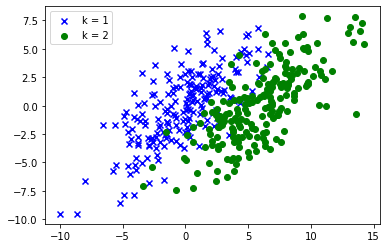

In [713]:
plt.scatter(x_class1[:,:1], x_class1[:,1:], color='blue', marker = 'x') # first class, x shape
plt.scatter(x_class2[:,:1], x_class2[:,1:], color='green', marker = 'o')# second class, circle shape

plt.legend(['k = 1', 'k = 2'])

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat\mu_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat\mu_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [714]:
def cost(data, R, Mu):
    N, D = data.shape # TODO
    K = Mu.shape[1] # TODO
    J = 0
    for n in range(N):
      for k in range(K):
        J += R[n, k] * np.linalg.norm(data[n,:] - Mu[:,k])
    return J

    

**b) [4pts]** K-Means assignment step.

In [715]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape # TODO: Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N, K)) # TODO
    # TODO assign all r[:, k]
    for k in range(K):
        r[:, k] = np.sum(np.square((data - Mu[:, k])), axis=1)
    arg_min = np.argmin(r, axis=1) # TODO: argmax/argmin along dimension 1
    R_new = np.zeros((N, K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[np.arange(N), arg_min] = 1 # TODO Assign to 1
    return R_new

**c) [2pts]** K-Means refitting step.

In [716]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # TODO: number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO: number of clusters
    denom = np.sum(R, axis=0)
    Mu_new = data.T @ R / denom # TODO
    return Mu_new

**d) [4pts]** Run this cell to call the K-Means algorithm.

In [717]:
N, D = data.shape # TODO
K = 2 # TODO
max_iter = 100
class_init = np.random.binomial(1.0, 0.5, size=N) # TODO
R = np.vstack([class_init, 1 - class_init]).T # TODO

Mu = np.zeros([D, K])
Mu[:, 1] = 1.0
#R.T.dot(data), np.sum(R, axis=0)

for it in range(max_iter):
    R = km_assignment_step(data, Mu) # TODO
    Mu = km_refitting_step(data, R, Mu) # TODO
    print(it, cost(data, R, Mu))

class_1 = data[np.where(R[:,0]),:].reshape((-1, K)) # TODO
class_2 = data[np.where(R[:,1]),:].reshape((-1, K)) # TODO

0 1426.493885503649
1 1401.5598418140935
2 1390.7154276126969
3 1380.4478000562278
4 1373.8163991704716
5 1371.1013829942206
6 1370.493496356509
7 1369.5099457733354
8 1368.3070808184677
9 1368.3070808184677
10 1368.3070808184677
11 1368.3070808184677
12 1368.3070808184677
13 1368.3070808184677
14 1368.3070808184677
15 1368.3070808184677
16 1368.3070808184677
17 1368.3070808184677
18 1368.3070808184677
19 1368.3070808184677
20 1368.3070808184677
21 1368.3070808184677
22 1368.3070808184677
23 1368.3070808184677
24 1368.3070808184677
25 1368.3070808184677
26 1368.3070808184677
27 1368.3070808184677
28 1368.3070808184677
29 1368.3070808184677
30 1368.3070808184677
31 1368.3070808184677
32 1368.3070808184677
33 1368.3070808184677
34 1368.3070808184677
35 1368.3070808184677
36 1368.3070808184677
37 1368.3070808184677
38 1368.3070808184677
39 1368.3070808184677
40 1368.3070808184677
41 1368.3070808184677
42 1368.3070808184677
43 1368.3070808184677
44 1368.3070808184677
45 1368.3070808184677


In [718]:
misclassification_rate = (np.sum(labels[np.where(R[:, 0])]) + np.sum(1 - labels[np.where(R[:, 1])])) / N
print("misclassification rate: " + str(misclassification_rate))

misclassification rate: 0.2475


**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


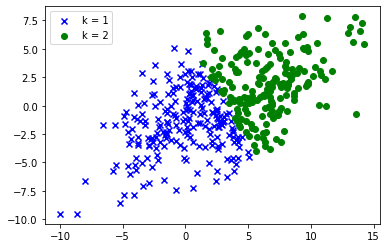

In [719]:
plt.scatter(class_1[:,0], class_1[:,1], color='blue', marker = 'x') # first class, x shape
plt.scatter(class_2[:,0], class_2[:,1], color='green', marker = 'o')# second class, circle shape

plt.legend(['k = 1', 'k = 2'])

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [720]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [721]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape  # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    L = 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    for n in range(N):
      T = 0.
      for k in range(K):
        prob = normal_density(data[n], Mu[:, k], Sigma[k])
        T += prob * Pi[k]
        log_T = np.log(T)
      L += log_T
    return L



**b) [5pts]** Gaussian Mixture Expectation Step.

In [722]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    Gamma = np.zeros((N, K)) # TODO zeros of shape (N,K), matrix of responsibilities

    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    for n in range(N):
      for k in range(K):
        prob = normal_density(data[n], Mu[:, k], Sigma[k])
        Gamma[n, k] = prob * Pi[k]
      denom = np.sum(Gamma[n, :])
      Gamma[n, :] = Gamma[n, :] / denom
    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [723]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # TODO number of mixtures
    Nk = np.sum(Gamma, axis=0) # TODO Sum along first axis 
    Mu = np.zeros((D, K)) # TODO
    Sigma = [np.zeros((D, D)) for k in range(K)] # TODO

    # TODO: fill in Sigma[k] for each k
    prod = data.T @ Gamma
    for k in range(K):
        cov = np.zeros((D, D))
        Mu[k] = prod[k] / Nk[k]
        for n in range(N):
            diff = data[n] - Mu[:, k]
            cov = cov + Gamma[n, k] * np.outer(diff, diff)
        Sigma[k] = cov / Nk[k]
    Pi = Nk / N # TODO
    return Mu, Sigma, Pi

**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [724]:
N, D = data.shape # TODO
K = 2 # TODO
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 200

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi) # TODO
    Mu, Sigma, Pi = gm_m_step(data, Gamma) # TODO

class_1 = data[np.where(Gamma[:, 0] > .5),:].reshape((-1, K)) # TODO
class_2 = data[np.where(Gamma[:, 1] >= .5),:].reshape((-1, K)) # TODO

In [725]:
misclassification_rate = (np.sum(labels[np.where(Gamma[:, 0] > .5)]) + np.sum(1 - labels[np.where(Gamma[:, 1] >= .5)])) / N
print("misclassification rate: " + str(misclassification_rate))

misclassification rate: 0.0775


**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

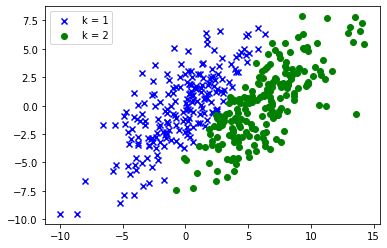

In [726]:
plt.scatter(class_1[:,0], class_1[:,1], color='blue', marker = 'x') # first class, x shape
plt.scatter(class_2[:,0], class_2[:,1], color='green', marker = 'o')# second class, circle shape

plt.legend(['k = 1', 'k = 2'])

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 


ANSWER:
- The EM model performed much better than the k-Means model. The EM model had a final misclassification rate of 7.75% while k-Means had 24.75%. 

- k-Means converged within just a few iterations while the EM model converged more slowly. The k-Means bottleneck is that it converged to a local optimum. Different initial partitions can result in different final clusters. The bottle neck of the EM model is that it takes longer to train (converges slowly initially) as well as outliers that lie in regions where the two true distributions overlap (i.e. bottleneck is the initial distributions too close together)

- Given the parameter initializations, the more horizontal the initial data distributions are (hence the data are more spread out horizontally), the better the k-Means algorithm performs. However, the EM algorithm performance does not really depend on the different data realizations. In other words, the K-Means algorithm is more sensitive to the observed data (the misclassification rate across 5 runs differed by almost 10%, whereas the EM algorithm is not (misclassification rate across 5 runs were all around 7-9%.

- If I increase the number K of clusters, k-Means might perform better than EM if the clusters are close together.

In [ ]:
# your code here, if you have any